In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.cross_validation import cross_val_predict
import re

/Users/dwhitehead/Documents/github/hearthstone_analytics/vhearthstone_analytics/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def load_data(wdir):
    filename = wdir + 'clean_cards.csv'
    df = pd.DataFrame.from_csv(filename, sep='\t', encoding='utf-8')
    return df

In [3]:
def filter_data(df):
    # remove non-minions
    df = df[df['type'].isin(['minion'])]
    
    # remove cost outliers
    df = df[df['cost'] <= 10]
    
    # remove boss
    df['text'].fillna(
        value='',
        inplace=True
    )
    df['boss'] = df['text'].apply(lambda x: 1 if 'boss' in x else 0)
    df = df[df['boss'] == 0]
    
    # remove weird sets
    collectibles = ['core', 'expert1', 'naxx', 'gvg', 'brm', 'tgt', 'loe', 'promo', 'reward', 'og']
    collectibles = ['core']
    df = df[df['set'].isin(collectibles)]
    
    # removing individual cards
    boss_cards = ['animated_statue']
    removed_cards = ['avatar_of_the_coin']
    outliers = ['the_ancient_one']
    hero_summons = [
        'searing_totem',
        'stoneclaw_totem',
        'wrath_of_air_totem',
        'healing_totem',
        'silver_hand_recruit'
    ]
    card_exclusions = boss_cards + removed_cards + outliers + hero_summons
    df = df[~df['name'].isin(card_exclusions)]
    
    return df

In [43]:
def add_features(df):
    # card draw
    df['self_card_draw'] = df['text'].apply(
        lambda x: 1 if ('draw' in x
            and 'card' in x
            and 'opponent' not in x
        ) else 0
    )
    # health
    df['self_restore_health'] = df['text'].apply(
        lambda x: int(
            x[x.find('_health')-1:x.find('_health')]
        ) if ('restore' in x
            and 'health' in x
            and 'opponent' not in x
        ) else 0
    )
    # damage
    df['deal_damage'] = df['text'].apply(
        lambda x: int(
            x[x.find('_damage')-1:x.find('_damage')]
        ) if ('deal' in x and 'damage' in x) else 0
    )
    # attack buff
    df['attack_buff'] = df['text'].apply(
        lambda x: int(
            x[x.find('_attack')-1:x.find('_attack')]
        ) if ('+' in x and 'attack' in x) else 0
    )
    # attack buff range
    # spell damage
    df['spell_damage'] = df['text'].apply(
        lambda x: int(
            x[x.find('spell_damage_+') + len('spell_damage_+'):x.find('spell_damage_+') + len('spell_damage_+') + 1]
        ) if ('spell_damage_+' in x) else 0
    )
    # summon
    df['self_summon'] = df['text'].apply(
        lambda x: int(
            x[x.find('_summon_a_') + len('_summon_a_'):x.find('_summon_a_') + len('_summon_a_') + 3]
        ) if ('_summon_a_' in x and 'opponent' not in x) else 0
    )
    # other ability
    df['other_ability'] = df['text'].apply(
        lambda x: int(x[x.find('_damage')-1:x.find('_damage')]) if ('deal' in x
            and 'damage' in x
        ) else 0
    )
    # other ability
    df['other_ability'] = df['text'].apply(
        lambda x: int(x[x.find('_damage')-1:x.find('_damage')]) if ('deal' in x
            and 'damage' in x
        ) else 0
    )
    # other ability
    df['other_ability'] = df['text'].apply(
        lambda x: int(x[x.find('_damage')-1:x.find('_damage')]) if ('deal' in x
            and 'damage' in x
        ) else 0
    )
    
    
    return df

In [45]:
minions = ['murloc_tidehunter', 'sheep', 'northshire_cleric', 'frog', 'voodoo_doctor', 'elven_archer', 'kobold_geomancer']
df = add_features(df)
addl_cols = ['name', 'battlecry', 'self_card_draw', 'self_restore_health', 'deal_damage', 'spellDamage', 'attack_buff']
# print df['self_card_draw'].sample(5)
print df[df['name'].isin(minions)][addl_cols]

                   name  battlecry  self_card_draw  self_restore_health  \
373   northshire_cleric          0               1                    0   
696                frog          0               0                    0   
798        elven_archer          1               0                    0   
1027              sheep          0               0                    0   
1146      voodoo_doctor          1               0                    2   
1433  murloc_tidehunter          1               0                    0   
1667   kobold_geomancer          0               0                    0   

      deal_damage  spellDamage  attack_buff  
373             0            0            0  
696             0            0            0  
798             1            0            0  
1027            0            0            0  
1146            0            0            0  
1433            0            0            0  
1667            0            1            0  


In [11]:
def train_cv_test_split(df, split_sizes=[1.0, 0.0, 0.0]):
    assert sum(split_sizes) == 1
    train_size = split_sizes[0]
    cv_size = split_sizes[1]
    test_size = split_sizes[2]
    train, test = train_test_split(df, test_size=test_size)
    train, cv = train_test_split(train, test_size=cv_size)
    return train, cv, test

In [5]:
def human_readable_coefficients(df, predictor):
    return pd.DataFrame(
        zip(df.columns, predictor.coef_[0]),
        columns=['features', 'predicted_coefficients']
    )

In [ ]:
# regex examples
# >>> re.findall(r'\d+', '<b>battlecry:</b>_summon_a_1/1_murloc_scout.')
# ['1', '1']

In [6]:
wdir = '/Users/dwhitehead/Documents/github/hearthstone_analytics/'
df_og = load_data(wdir)
df = filter_data(df_og)
df = add_features(df)
df['intercept'] = 1
dep_var = ['cost']
indep_vars = [
    'attack',
    'health',
    'charge',
    'taunt',
    'stealth',
    'divine_shield',
    'intercept'
]
print df[dep_var].sample(5)
print df[indep_vars].sample(5)

      cost
1621   4.0
198    6.0
13     2.0
316    1.0
1283   6.0
      attack  health  charge  taunt  stealth  divine_shield  intercept
2043     4.0     3.0       0      0        0              0          1
1524     2.0     4.0       0      0        0              0          1
1866     2.0     2.0       0      1        0              0          1
798      1.0     1.0       0      0        0              0          1
1769     1.0     2.0       0      1        0              0          1


In [7]:
lr = linear_model.LinearRegression(
    fit_intercept=True,
    normalize=False,
    copy_X=True,
    n_jobs=1
)
lr.fit(
    X=df[indep_vars],
    y=df[dep_var]
)
df_coefficients = human_readable_coefficients(
    df[indep_vars],
    lr
)
df['predictions'] = lr.predict(df[indep_vars])
colss = dep_var + indep_vars + ['name', 'predictions']
df_coefficients

/Users/dwhitehead/Documents/github/hearthstone_analytics/vhearthstone_analytics/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


,features,predicted_coefficients
0,attack,0.568349
1,health,0.512580
2,charge,0.473374
3,taunt,-0.455974
4,stealth,0.000000
5,divine_shield,0.000000
6,intercept,0.000000


In [8]:
smlr = sm.OLS(df[dep_var], df[indep_vars])
result = smlr.fit()
print result.summary()

                            OLS Regression Results                            
Dep. Variable:                   cost   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     100.0
Date:                Sun, 15 May 2016   Prob (F-statistic):           8.33e-27
Time:                        14:31:48   Log-Likelihood:                -77.153
No. Observations:                  69   AIC:                             164.3
Df Residuals:                      64   BIC:                             175.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
attack            0.5683      0.061      9.348

[('red', 'attack'), ('blue', 'health'), ('green', 'charge'), ('yellow', 'taunt'), ('pink', 'stealth'), ('grey', 'divine_shield')]


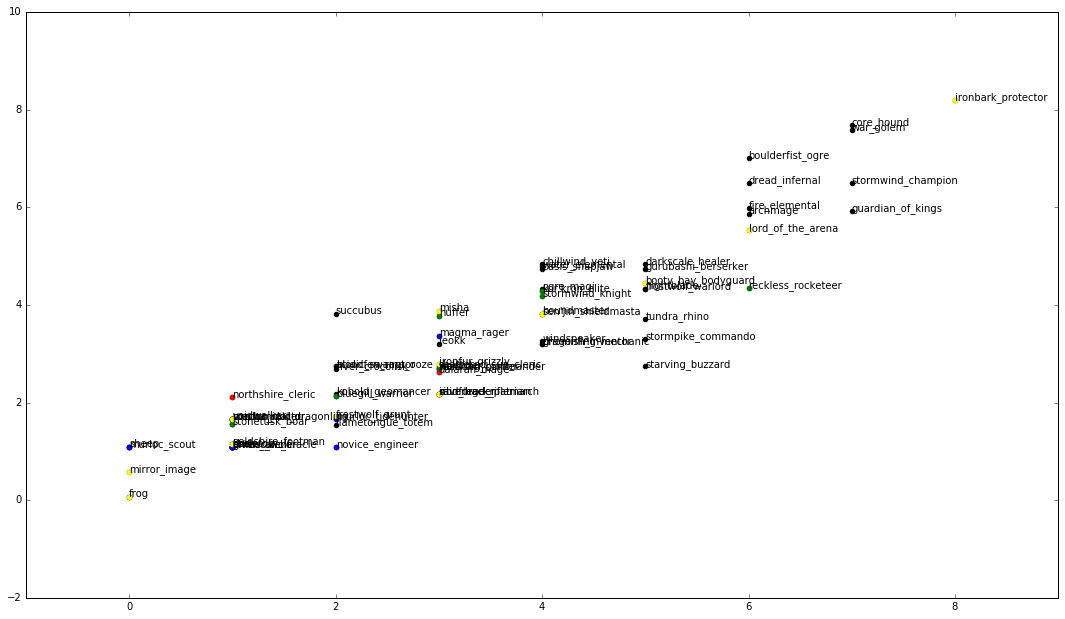

In [9]:
colors = [
    'red',
    'blue',
    'green',
    'yellow',
    'pink',
    'grey'
]
print zip(colors, indep_vars[:-1])
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.scatter(
    x=df['cost'],
    y=df['predictions'],
    color='black'
)
for i, var in enumerate(indep_vars[:-1]):
    ax.scatter(
        x=df[df[var] == 1]['cost'],
        y=df[df[var] == 1]['predictions'],
        color=colors[i]
    )
for index, row in df.iterrows():
    ax.annotate(
        row['name'],
        xy= (float(row['cost']), float(row['predictions']))
    )
plt.show()

In [13]:
for i in xrange(0,9):
    print
    cost = i
    mean = df[df['cost'] == i]['predictions'].mean()
    std = df[df['cost'] == i]['predictions'].std()
    print 'cost', cost
    print '-'*20
    print 'mean', mean
    print 'std', std    
    for idx, row in df[df['cost'] == i].sort(columns='predictions', ascending=False).iterrows():
        print '-'*5
        print 'name', row['name']
        print 'text', row['text']
        dev = (row['predictions'] - mean) / std
        print 'dev', dev
#         if abs(dev) > 1.5:
#             print row[colss + ['text']]
#             print 'dev', dev


cost 0
--------------------
mean 0.705821132042
std 0.490320769564
-----
name sheep
text 
dev 0.783194282348
-----
name murloc_scout
text 
dev 0.783194282348
-----
name mirror_image
text <b>taunt</b>
dev -0.260496059474
-----
name frog
text <b>taunt</b>
dev -1.30589250522

cost 1
--------------------
mean 1.4089517278
std 0.350229107972
-----
name northshire_cleric
text whenever_a_minion_is_healed,_draw_a_card.
dev 2.01595181829
-----
name voidwalker
text <b>taunt</b>
dev 0.714021192644
-----
name voodoo_doctor
text <b>battlecry:</b>_restore_2_health.
dev 0.711632647058
-----
name murloc_raider
text 
dev 0.711632647058
-----
name mechanical_dragonling
text 
dev 0.711632647058
-----
name stonetusk_boar
text <b>charge</b>
dev 0.440454632511
-----
name goldshire_footman
text <b>taunt</b>
dev -0.749533886331
-----
name boar
text 
dev -0.911158339658
-----
name elven_archer
text <b>battlecry:</b>_deal_1_damage.
dev -0.911158339658
-----
name skeleton
text <b></b>_
dev -0.911158339658
-----

/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [75]:
print df[df['cost'] > 10][dep_var + indep_vars + ['name']]

      cost  attack  health  charge  taunt  stealth  divine_shield  intercept  \
573   50.0    20.0    20.0       0      0        0              0          1   
615   25.0     8.0     8.0       0      0        0              0          1   
1404  12.0     8.0     8.0       0      0        0              0          1   
2084  12.0     8.0     8.0       0      0        0              0          1   

                 name  
573          golemagg  
615      molten_giant  
1404  clockwork_giant  
2084   mountain_giant  


In [77]:
print df[df['predictions'] > 10][dep_var + indep_vars + ['name', 'predictions']]

      cost  attack  health  charge  taunt  stealth  divine_shield  intercept  \
47    10.0     1.0    80.0       0      1        0              0          1   
573   50.0    20.0    20.0       0      0        0              0          1   
680   10.0    12.0    12.0       0      0        0              0          1   
871   10.0     2.0    95.0       0      1        0              0          1   
1080  10.0    12.0    12.0       0      0        0              0          1   
1168   9.0    30.0    30.0       0      0        0              0          1   
1196  10.0     9.0    80.0       0      0        0              0          1   
1276  10.0    11.0    11.0       0      0        0              0          1   

                       name  predictions  
47      gearmaster_mechazod    11.951274  
573                golemagg    17.768093  
680   deathwing,_dragonlord    10.945346  
871     gearmaster_mechazod    14.654265  
1080              deathwing    10.945346  
1168        the_ancie

In [99]:
for col in df.columns:
    print df[df.name == 'gearmaster_mechazod'][col]

47     0
871    0
Name: enraged, dtype: int64
47     0
871    0
Name: evil_glow, dtype: int64
47     tb
871    tb
Name: set, dtype: object
47     0
871    0
Name: inspire, dtype: int64
47     0
871    0
Name: durability, dtype: int64
47     <b>boss</b>\nat_the_beginning_of_each_turn,_me...
871    <b>boss</b>\nmechazod_wins_if_he_defeats_eithe...
Name: text, dtype: object
47     0
871    0
Name: secret, dtype: int64
47     0
871    0
Name: freeze, dtype: int64
47     10.0
871    10.0
Name: cost, dtype: float64
47     0
871    0
Name: divine_shield, dtype: int64
47     0
871    0
Name: immunetospellpower, dtype: int64
47     0
871    0
Name: adjacent_buff, dtype: int64
47              hrw02_1
871    tb_coop_mechazod
Name: id, dtype: object
47     NaN
871    NaN
Name: playerClass, dtype: object
47     0
871    0
Name: choose_one, dtype: int64
47     0
871    0
Name: ritual, dtype: int64
47     0
871    0
Name: poisonous, dtype: int64
47     0
871    0
Name: ai_must_play, dtype: int64
47  

In [85]:
print list(df['playerClass'].unique())

[u'priest', nan, u'warlock', u'rogue', u'shaman', u'hunter', u'paladin', u'warrior', u'druid', u'dream', u'mage']


In [86]:
print df[df.invisibledeathrattle > 0]

      enraged  evil_glow   set  inspire  durability  secret  freeze  cost  \
31          0          0  naxx        0           0       0       0   0.0   
47          0          0    tb        0           0       0       0  10.0   
475         0          0   brm        0           0       0       0   2.0   
910         0          0   brm        0           0       0       0   1.0   
916         0          0  naxx        0           0       0       0   3.0   
1037        0          0  naxx        0           0       0       0   3.0   
1865        0          0   brm        0           0       0       0   2.0   
2023        0          0   brm        0           0       0       0   1.0   

      divine_shield  immunetospellpower     ...       morph windfury  \
31                0                   0     ...           0        0   
47                0                   0     ...           0        0   
475               0                   0     ...           0        0   
910               

In [110]:
l = [type(x) for x in df.text.unique()]
for i in df.text.unique():
    if isinstance(i, float):
        print i, type(i)

nan <type 'float'>


In [121]:

print df[df['text'].isnull() == True]

Empty DataFrame
Columns: [enraged, evil_glow, set, inspire, durability, text, secret, freeze, cost, divine_shield, immunetospellpower, adjacent_buff, id, playerClass, choose_one, ritual, poisonous, ai_must_play, charge, overload, attack, invisibledeathrattle, health, spellDamage, combo, type, taunt, topdeck, forgetful, deathrattle, stealth, name, artist, morph, windfury, rarity, tag_one_turn_effect, race, aura, battlecry, silence]
Index: []

[0 rows x 41 columns]


In [81]:
print df[df['name'] == 'living_lava'][colss + ['set']]

      cost  attack  health  charge  taunt  stealth  divine_shield  intercept  \
1940   0.0     6.0     6.0       0      1        0              0          1   

             name  predictions  set  
1940  living_lava     5.811602  brm  


In [14]:
print df.columns

Index([             u'enraged',            u'evil_glow',
                        u'set',              u'inspire',
                 u'durability',                 u'text',
                     u'secret',               u'freeze',
                       u'cost',        u'divine_shield',
         u'immunetospellpower',        u'adjacent_buff',
                         u'id',          u'playerClass',
                 u'choose_one',               u'ritual',
                  u'poisonous',         u'ai_must_play',
                     u'charge',             u'overload',
                     u'attack', u'invisibledeathrattle',
                     u'health',          u'spellDamage',
                      u'combo',                 u'type',
                      u'taunt',              u'topdeck',
                  u'forgetful',          u'deathrattle',
                    u'stealth',                 u'name',
                     u'artist',                u'morph',
                   u'windfury',